In [ ]:
from wtlike import *
import numpy as np

# wtlike tutorial

> A step by step guide

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

Either run this [notebook](https://github.com/tburnett/wtlike/blob/master/nbs/99_tutorial.ipynb), or copy the cells into a new notebook.

`wtlike` is on PyPI--to install it,

```
pip install wtlike
```
Next we generate a simulated on-the-fly dataset in lieu of downloading the 3-GB of so of the *fermi* data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [ ]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6 /s
- effective area -- 3000 cm^2 

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin the photons into daily time-bins, called "cells". (That can be easily redone.)

In [ ]:
config=Config(cachepath=None, datapath=None)
test_sim = Simulation('flare_sim', src_flux=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, config=config, time_bins=(0,0,1))

generated 19078 photons
SourceData: Source flare_sim with:
	 data:        19,078 simulated photons over 30.0 days.
	 exposure:     8,640 intervals,  average flux 3000 cm^2 for 2.6 Ms
	 rates:  source 1.45e-06/s, background 1.01e-06/s, S/N ratio 1.43e+00
CellData: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>5 & n>2


Now make a light curve!

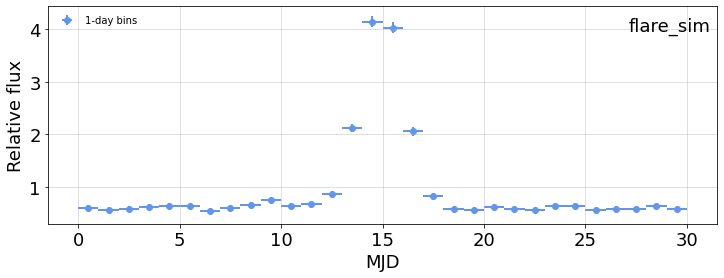

In [ ]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation. The first few cells are:

In [ ]:
daily.cells.head(2)

,t,tw,e,n,w,S,B
0,0.5,1.0,258.3,522,"[0.65799403, 0.08224245, 0.8980113, 0.9066117,...",373.37,260.36
1,1.5,1.0,259.2,478,"[0.83283037, 0.05109548, 0.031586714, 0.671001...",374.67,261.27


The Kerr likelihood function for a cell is a function of $w$, the list of weights, and $S$, an estimate for the total signal counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ S  $$

where $\alpha$ is the variation from the nominal zero. The background is assumed to be constant here, as it usually is the region surrounding sources of interest. 
The relative flux is $1+\alpha$. 

We generate an approximate representation of this function by fitting it to a 3-parameter Poisson-like function, which easily provides the values of interest.

In [ ]:
daily.fluxes.head(2)

,t,tw,n,e,ts,flux,errors,limit
0,0.5,1.0,522,258.3,366.8,0.60,"(-0.047, 0.049)",0.68
1,1.5,1.0,478,259.2,336.6,0.57,"(-0.046, 0.048)",0.65


#### About DataFrames
The properties `photons`, `exposure`, `cells`, `fits`, and `fluxes` are [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) objects.
For those unfamiliar with pandas, note that one can create "csv" files with the method `to_csv(`*filename*`)`.

The function `query` is very useful: To select the cells with flux>3,

In [ ]:
daily.fluxes.query('flux>3')

,t,tw,n,e,ts,flux,errors,limit
14,14.5,1.0,1685,259.2,10585.2,4.14,"(-0.106, 0.108)",4.32
15,15.5,1.0,1680,259.2,10168.7,4.03,"(-0.105, 0.106)",4.21


## Views
A `WtLike` object provides a function `view`, which returns a copy but with a different binning. 
So if we want a detailed look at the flare, we can choose an interval. The parameters specify an interval 10 days after the start, and 10 days before the end, with 1/day or 6-hour bins.

CellData: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>5 & n>2


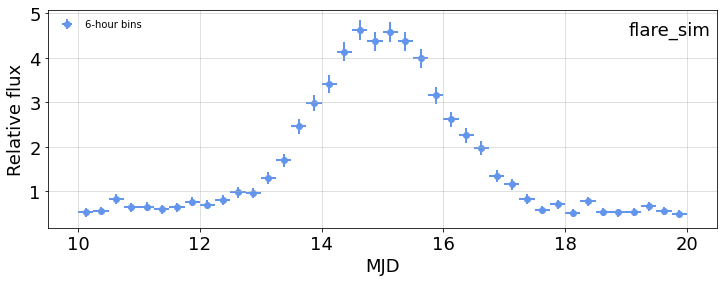

In [ ]:
qday = daily.view(10, -10, 0.25)
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis and returns a view of it. 

LightCurve: select 40 cells for fitting with e>5 & n>2
Bayesian Blocks: using penalty 0.05
	Partitioned 40 cells into 10 blocks, using LikelihoodFitness 
LightCurve: Loaded 10 / 10 cells for fitting


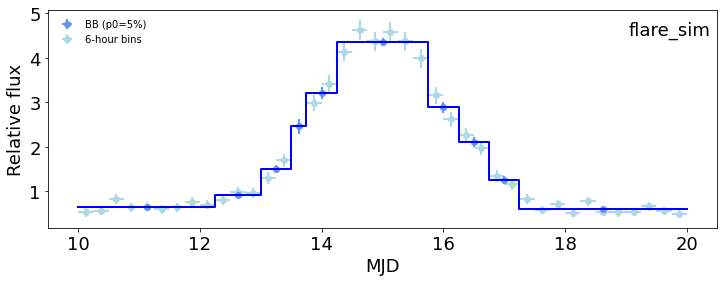

In [ ]:
bb = qday.bb_view();bb.plot();

This creates variable-sized cells corresponding to the Bayesian Block analysis, the fits for which are shown here:

In [ ]:
bb.fluxes

,t,tw,n,e,ts,flux,errors,limit
0,11.12,2.25,1206,64.8,972.5,0.66,"(-0.033, 0.033)",0.71
1,12.62,0.75,452,64.8,608.2,0.92,"(-0.063, 0.065)",1.03
2,13.25,0.50,384,64.8,1021.2,1.50,"(-0.094, 0.097)",1.67
3,13.62,0.25,276,64.8,1142.7,2.46,"(-0.165, 0.171)",2.76
4,14.00,0.50,689,64.8,3501.4,3.21,"(-0.133, 0.136)",3.44
5,15.00,1.50,2660,64.8,17085.6,4.35,"(-0.089, 0.09)",4.50
6,16.00,0.50,640,64.8,3098.0,2.89,"(-0.126, 0.129)",3.11
7,16.50,0.50,499,64.8,1845.8,2.12,"(-0.109, 0.112)",2.31
8,17.00,0.50,358,64.8,715.2,1.26,"(-0.087, 0.09)",1.41
9,18.62,2.75,1437,64.8,1066.4,0.61,"(-0.029, 0.029)",0.66


### Getting help
This jupyterlab environment allows easy exploration of help for any class or function.
The two classes so far:

In [ ]:
Simulation = Simulation
Simulation?

Init signature:
Simulation(
    name,
    src_flux,
    tstart,
    tstop,
    bkg_rate=1e-06,
    efun=3000,
    wt_signif=0.1,
)
Docstring:      <no docstring>
Init docstring:
- src_flux : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar, function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : now the width of the PSF in (r/rmax)**2 coordinates
File:           /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/simulation.py
Type:           type
Subclasses:     


In [ ]:
WtLike?

Init signature: WtLike(*pars, **kwargs)
Docstring:     
Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- pos

The three WtLike methods have (preliminary) help as well:

In [ ]:
WtLike.plot?

Signature: WtLike.plot(self, *pars, **kwargs)
Docstring:
Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim [None] -- convert to (start, stop) interpreted relative to start, stop if < start.
        - show_flux [False]-- convert y scale to photon flux
        - UTC [False] -- convert x scale to UTC years
-
        Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

    - cell_fits -- cell fits DataFrame
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specifed, will use '.' if many bins

In [ ]:
WtLike.view?

Signature: WtLike.view(self, *pars, exp_min=None)
Docstring:
Return a "view", a copy of this instance with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning

- exp_min [None] -- If specified, a different minimum exposure, in cm^2 Ms units to use for fitting
    from.
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/cell_data.py
Type:      function


## Using *Fermi* data.

The only change from the above code is that one substitues `PointSource` with the designation of a source, for `Simulation`. 

Also, the data files must be available, the config parameter `datapath` set to the relevant folder. 
Currently it is set by a line in `~/.config/wtlike/config.yaml`.  See the [Config help](https://tburnett.github.io/wtlike/config#Config).

This requires access to a packaged form of the photon data, a table allowing generation of weights, and the effective area table.
The source must have been analyzed with `gtlike` or `pointlike` to produce the weight table.

All are available in a 2-GB zip file.

The photon and spacecraft data can be checked with `check_data`

In [ ]:
config= Config() # file paths must be valid for following.
if config.valid:
    check_data()

Weekly folder "/home/burnett/wtlike_data/data_files" contains 678 weeks.
	 Last week, # 687, has 5.277 days, ends at UTC 2021-08-03 06:43


The configuration must be valid, with path to data existing

In [ ]:
if config.valid:
    source = PointSource('3C 279'); 
    print(source)

Source "3C 279" at: (l,b)=(305.104,57.062)


In [ ]:
if config.valid:
    wtl = WtLike(source, exp_min=50)

SourceData:  3C 279: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       180,481 photons from 2008-08-04 to 2021-07-30
	 exposure: 2,870,182 intervals,  average flux 2391 cm^2 for 85.7 Ms
	 rates:  source 4.68e-07/s, background 4.13e-07/s, S/N ratio 1.14e+00
CellData: Bin photon data into 677 1-week bins from 54683.0 to 59422.0
LightCurve: select 662 cells for fitting with e>50 & n>2


/home/burnett/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


If the data for this source has not been accessed on this machine before, it must be extracted to a cache, a process that takes some 10 min. Otherwise it is a few seconds to retrieve the cache.

Generate the (default weekly) light curve:

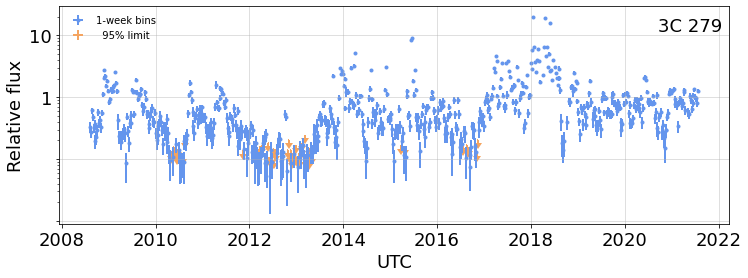

In [ ]:
if config.valid: wtl.plot(log=True, UTC=True);